# The Sahm Rule recession indicator

Jupyter notebook of the post from 08/02/2020 on [The Sahm Rule recession indicator](https://www.christhoung.com/2020/02/08/sahm-rule/).

[Sahm (2019)](https://www.hamiltonproject.org/papers/direct_stimulus_payments_to_individuals) makes the case for lump-sum payments to people in a recession to boost consumer expenditure. These payments should be *large enough* to be salient and maintain spending over (precautionary) saving e.g. on durables. Crucially, these payments must also be *timely* to provide a quick and early response to a recession.

The challenge for a stimulus response is knowing *when* to enact it. The National Bureau of Economic Research (NBER) is responsible for the [official identification](https://www.nber.org/cycles/recessions_faq.html) of recessions in the US. However, [this takes time](https://twitter.com/Claudia_Sahm/status/1129197360477888512) and we'd ideally have something that tells us whether we're in a recession in as close to real time as possible.

This is where the *Sahm Rule* comes in as a trigger for the payments. By the rule, payments would begin when (Sahm, 2019; Page 76):

> the three-month average national unemployment rate rises by at least 0.50 percentage points relative to its low in the previous 12 months

Sahm (2019) shows that this is effective as a US recession indicator, signalling a recession within months of its start. This is far quicker than the NBER and, applied to historical data, has not resulted in a false positive since 1970.

The [whole paper](https://www.hamiltonproject.org/papers/direct_stimulus_payments_to_individuals) is worth a look. It's very readable and, as a policy paper, covers a range of other considerations including the role of policymakers' commitment, practicalities of implementation, and policy evaluation.

The rest of this post reproduces the [Sahm Rule recession indicator](https://fred.stlouisfed.org/series/SAHMCURRENT) in Python.

In [1]:
import numpy as np
from pandas import PeriodIndex, Series
import requests

import matplotlib.pyplot as plt
%matplotlib inline

## Download the data

We can download the US monthly unemployment series ([UNRATE](https://fred.stlouisfed.org/series/UNRATE)) using the [Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/) [API](https://research.stlouisfed.org/docs/api/fred/). It's free to register for an account and get an [API key](https://research.stlouisfed.org/docs/api/api_key.html).

If you're running this as a notebook, you'll need to store your own API key to `api_key` below:

In [2]:
api_key = ''  # Insert your own API key here

I'm not going to worry about the accompanying metadata etc and will focus instead on downloading the series values. The FRED API call of interest is [`series/observations`](https://research.stlouisfed.org/docs/api/fred/series_observations.html). The function below makes that API call using the [Requests](https://requests.readthedocs.io/en/master/) library, checks that the request was successful (status code 200) and returns a [pandas](https://pandas.pydata.org/) [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) object of the data.

In [3]:
def get_fred_series(series_id: str, api_key: str, *, frequency: str = 'M') -> Series:
    """Return the values of `series_id` as a pandas `Series` object."""

    response = requests.get(
        'https://api.stlouisfed.org/fred/series/observations',
        {'api_key': api_key,
         'series_id': series_id,
         'file_type': 'json', })

    # Raise an error if request not successful
    response.raise_for_status()

    # Return values as a `Series` object
    series = Series({observation['date']: float(observation['value'])
                     for observation in response.json()['observations']})
    series.index = PeriodIndex(series.index, freq=frequency)
    series.name = series_id

    return series

We can then download the data. Strictly, to simulate the situation a policymaker would be in, I should be using the real-time unemployment figures available at the time. For that I'd need to make calls to the [ALFRED API](https://research.stlouisfed.org/docs/api/fred/alfred.html), rather than the FRED API. I'm not going to bother with that here. Maybe next time...

*Update 21/05/2020: Re-run to extend the series to April 2020, when the impacts of COVID-19 become **very** apparent*.

In [4]:
unemployment_rate = get_fred_series('UNRATE', api_key)
unemployment_rate.tail(8).round(1)

2019-09     3.5
2019-10     3.6
2019-11     3.5
2019-12     3.5
2020-01     3.6
2020-02     3.5
2020-03     4.4
2020-04    14.7
Freq: M, Name: UNRATE, dtype: float64

## Calculate the Sahm Rule recession indicator

Having downloaded the series, calculate the Sahm Rule recession indicator:

In [5]:
def calculate_sahm_rule_indicator(series: Series, *, rolling_mean_window: int = 3, rolling_minimum_window: int = 12) -> Series:
    """Calculate the Sahm rule recession indicator from `series`."""
    rolling_mean = series.rolling(rolling_mean_window).mean()

    # One-period lag to avoid comparing the current period against itself
    rolling_minimum = rolling_mean.rolling(rolling_minimum_window).min().shift()

    return rolling_mean - rolling_minimum

In [6]:
sahm_indicator = calculate_sahm_rule_indicator(unemployment_rate)
sahm_indicator.tail(8).round(1)

2019-09    0.0
2019-10   -0.0
2019-11   -0.1
2019-12    0.0
2020-01    0.0
2020-02    0.0
2020-03    0.3
2020-04    4.0
Freq: M, Name: UNRATE, dtype: float64

We can then plot the series:

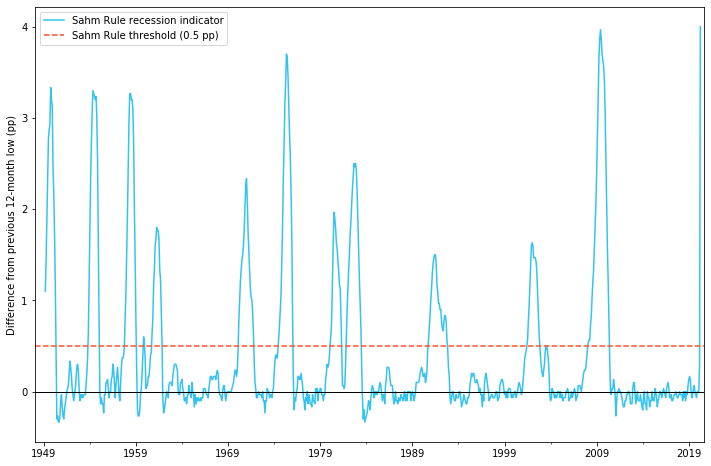

In [7]:
plt.figure(figsize=(12, 8))

# Plot the Sahm Rule recession indicator
sahm_indicator.plot(label='Sahm Rule recession indicator', color='#33C3F0')

limits = [
    -len(np.where(sahm_indicator.index < '1970')[0]),
     # Pad the right-hand side slightly to make the April 2020 figure clearer
     len(np.where(sahm_indicator.index > '1970')[0]) + 5,
]

# Horizontal lines for zero...
plt.plot(limits, [0.0, 0.0],
         label='_nolabel_', color='black', linewidth=1)

# ...and the 0.5 pp threshold
plt.plot(limits, [0.5, 0.5],
         label='Sahm Rule threshold (0.5 pp)', color='#FF4F2E', linestyle='--')

plt.xlim(limits)
plt.ylabel('Difference from previous 12-month low (pp)')

plt.legend()
plt.show()

See [here](https://github.com/ChrisThoung/website/tree/master/notebooks/2020-02-08_sahm-rule.ipynb) for this post as a Jupyter notebook.

## Data

Sahm, C. 'Sahm Rule recession indicator' [SAHMCURRENT], retrieved from FRED, Federal Reserve Bank of St. Louis  
[https://fred.stlouisfed.org/series/SAHMCURRENT](https://fred.stlouisfed.org/series/SAHMCURRENT)

US Bureau of Labor Statistics 'Unemployment rate' [UNRATE], retrieved from FRED, Federal Reserve of St. Louis  
[https://fred.stlouisfed.org/series/UNRATE](https://fred.stlouisfed.org/series/UNRATE)

## References

Sahm, C. (2019) 'Direct stimulus payments to individuals'
in Boushey, H., Nunn, R., Shambaugh, J. (eds)
*Recession ready: Fiscal policies to stabilize the American economy*,
*The Hamilton Project and the Washington Center for Equitable Growth*  
https://www.hamiltonproject.org/papers/direct_stimulus_payments_to_individuals